In [2]:
!pip install -U tensorflow-addons

In [64]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.6.0


'3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]'

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [66]:
train_path = "./Downloads/Final_Train_Test_thesis2.0/train"
test_path = "./Downloads/Final_Train_Test_thesis2.0/test"
x_train=[]  

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(72,72))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(72,72))

        x_test.append(img_arr)

In [67]:
import numpy as np
x_train=np.array(x_train)
x_test=np.array(x_test)

In [68]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [69]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (72, 72),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (72, 72),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 9921 images belonging to 3 classes.
Found 1420 images belonging to 3 classes.


In [70]:
y_train=training_set.classes
y_test=test_set.classes

In [71]:
num_classes = 3
input_shape = (72, 72, 3)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (9921, 72, 72, 3) - y_train shape: (9921, 3)
x_test shape: (1420, 72, 72, 3) - y_test shape: (1420, 3)


In [72]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 32
num_epochs = 200
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 3
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 1296


In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [74]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [75]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [76]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.03 ):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [77]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [78]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [80]:
import tensorflow as tf
import tensorflow.keras as tk
import tensorflow_addons as tfa
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/200
248/248 [==============================] - 49s 164ms/step - loss: 0.7706 - accuracy: 0.7210 - top-5-accuracy: 1.0000 - val_loss: 1.0859 - val_accuracy: 0.3526 - val_top-5-accuracy: 1.0000
Epoch 2/200
248/248 [==============================] - 39s 157ms/step - loss: 0.6363 - accuracy: 0.8033 - top-5-accuracy: 1.0000 - val_loss: 0.9286 - val_accuracy: 0.5501 - val_top-5-accuracy: 1.0000
Epoch 3/200
248/248 [==============================] - 39s 156ms/step - loss: 0.5880 - accuracy: 0.8383 - top-5-accuracy: 1.0000 - val_loss: 1.3111 - val_accuracy: 0.4096 - val_top-5-accuracy: 1.0000
Epoch 4/200
248/248 [==============================] - 39s 156ms/step - loss: 0.5295 - accuracy: 0.8761 - top-5-accuracy: 1.0000 - val_loss: 1.5093 - val_accuracy: 0.4050 - val_top-5-accuracy: 1.0000
Epoch 5/200
248/248 [==============================] - 39s 156ms/step - loss: 0.5126 - accuracy: 0.8868 - top-5-accuracy: 1.0000 - val_loss: 1.4988 - val_accuracy: 0.3854 - val_top-5-accuracy: 1.0000


In [81]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

45/45 [==============================] - 3s 64ms/step - loss: 0.9127 - accuracy: 0.7345 - top-5-accuracy: 1.0000
Test loss: 0.91
Test accuracy: 73.45%
Test top 5 accuracy: 100.0%


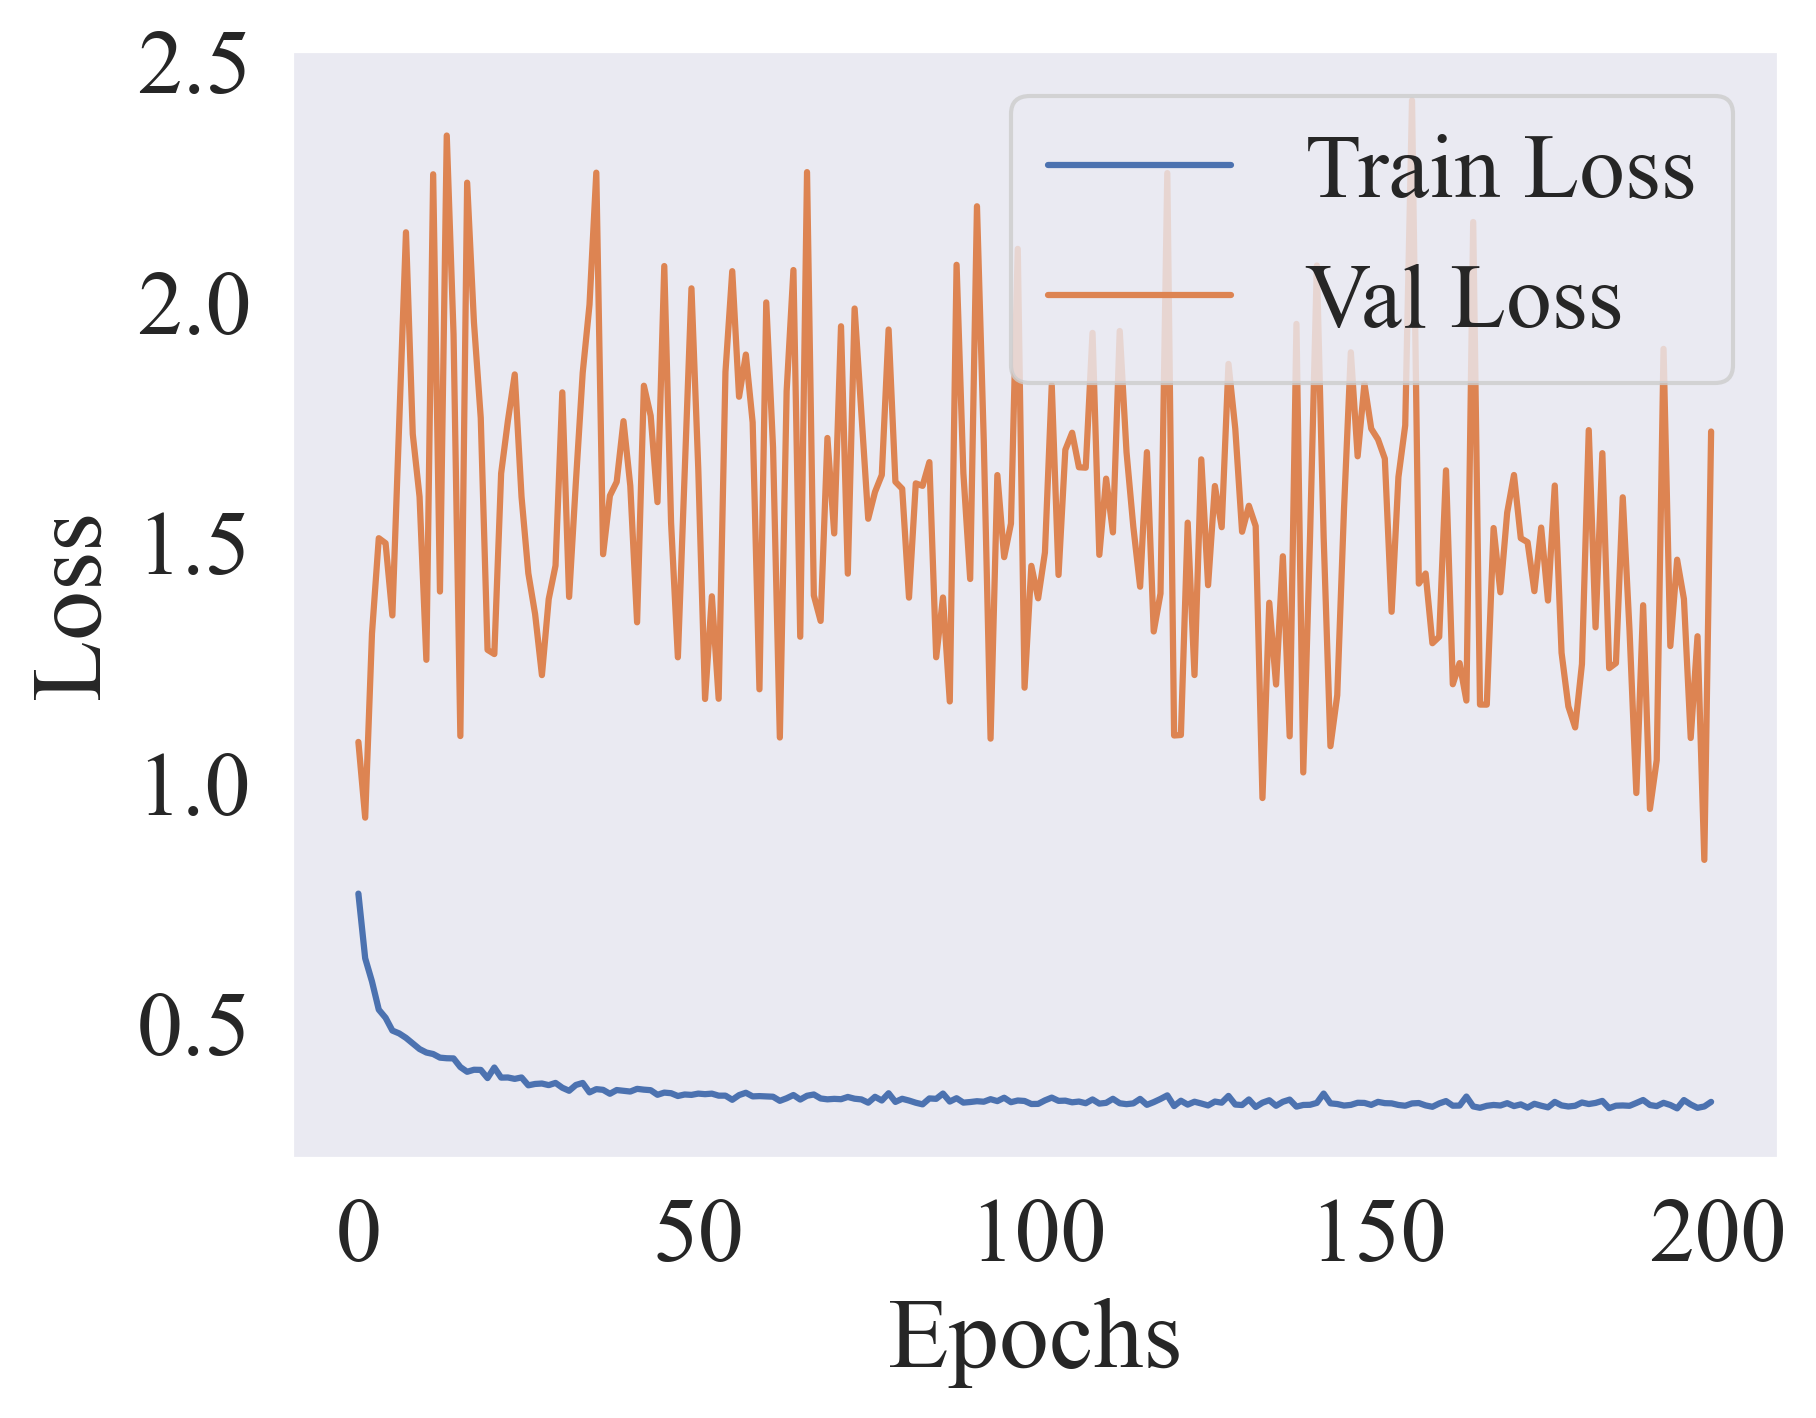

In [85]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Test'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
plt.legend()
plt.grid()
plt.show()

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])


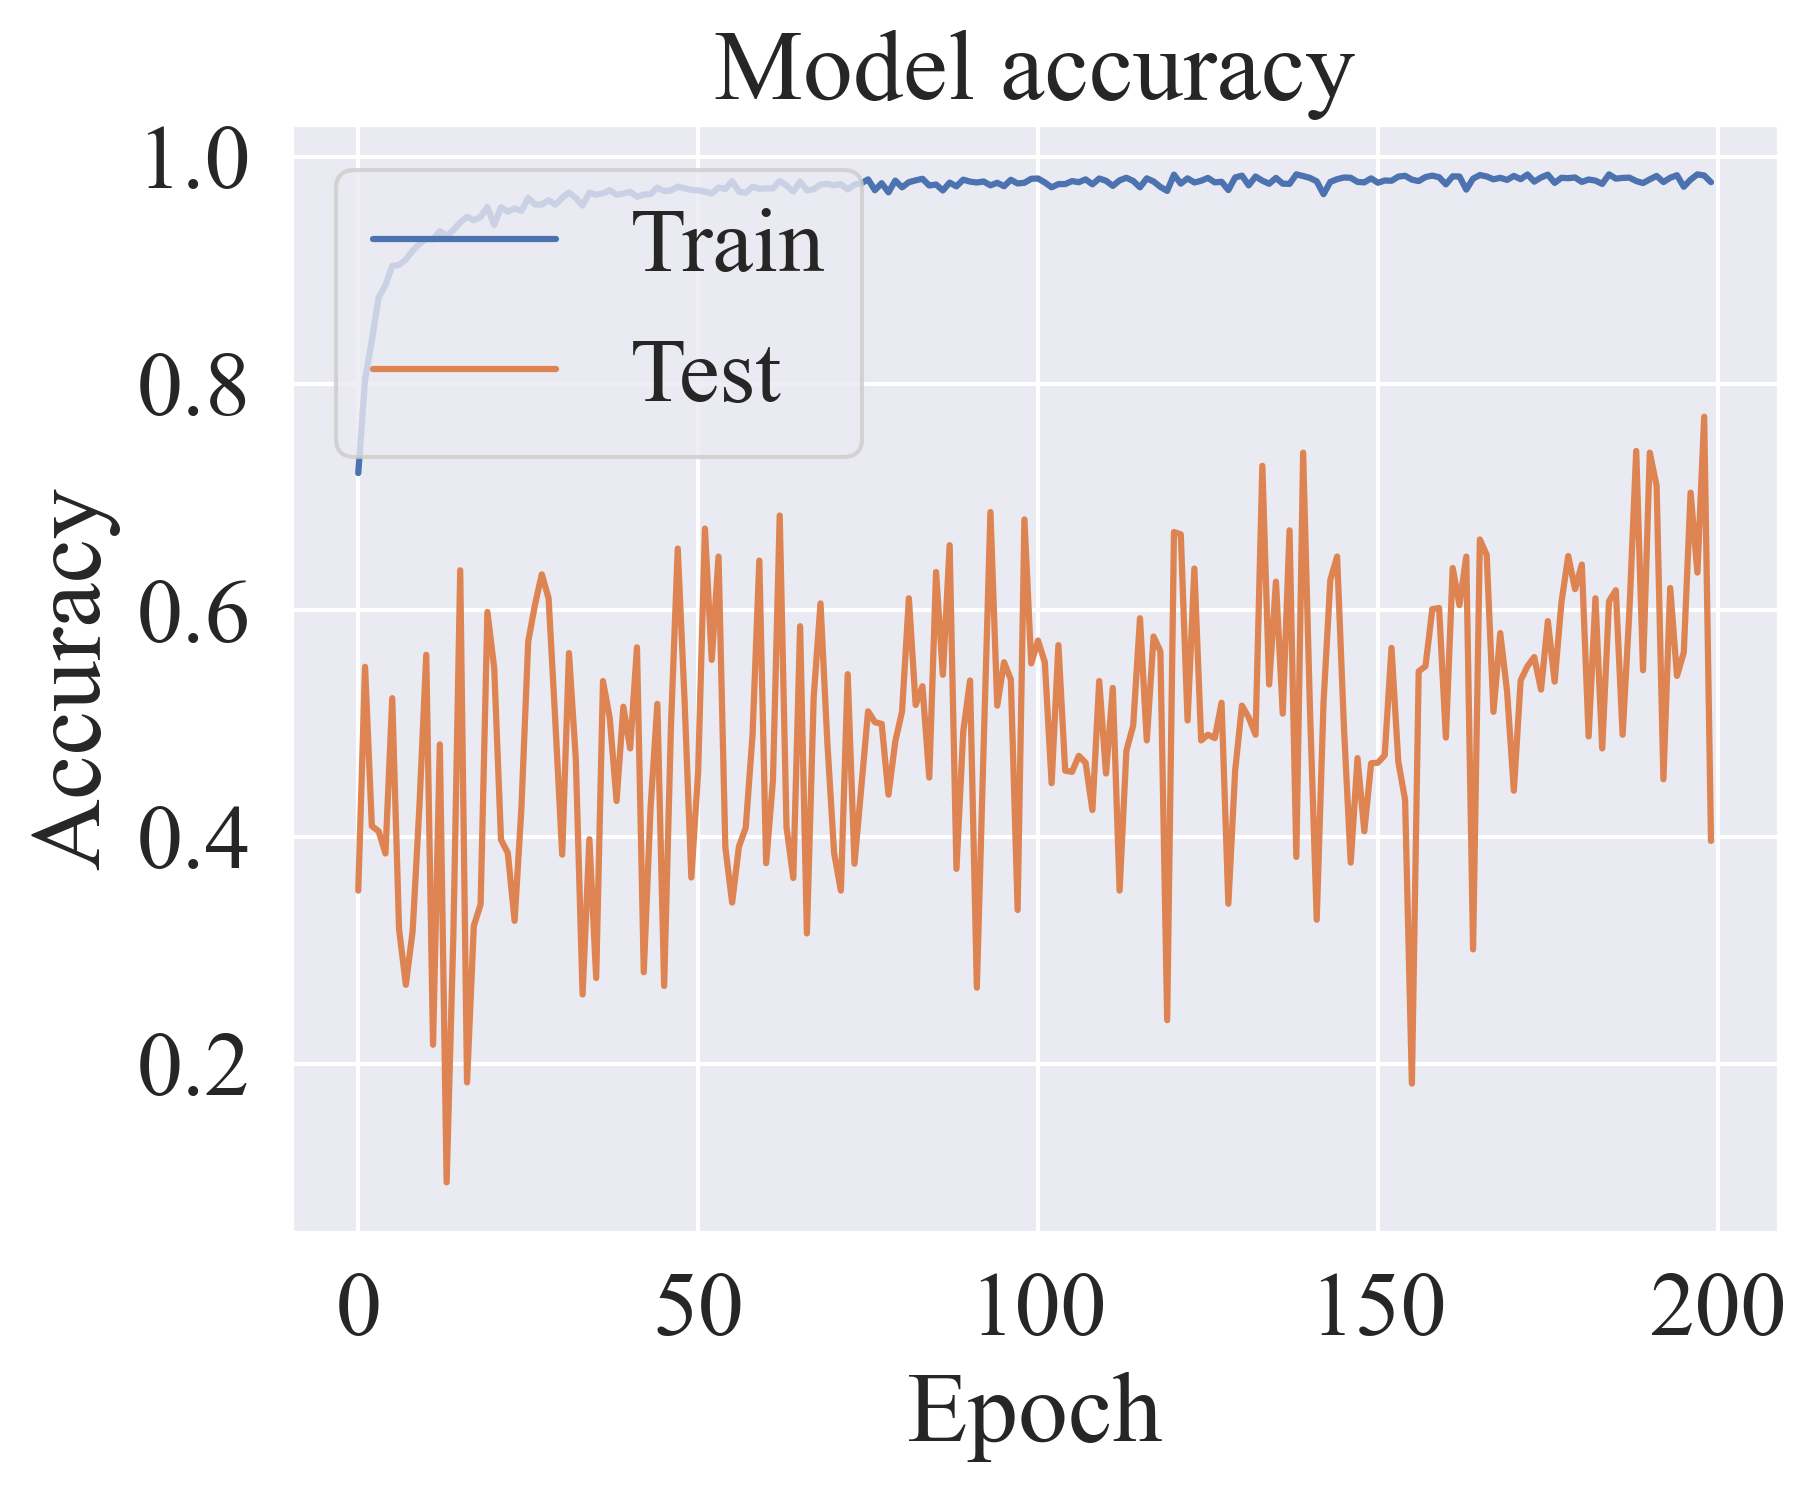

In [84]:
history_dict = history.history
print(history_dict.keys())
import matplotlib as mpl
loss =  history_dict['loss']
accuracy =  history_dict['accuracy']
val_loss =  history_dict['val_loss']
val_accuracy =  history_dict['val_accuracy']

plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
mpl.rcParams["figure.dpi"] = 300
plt.legend(['Train', 'Test'], loc='upper left')
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"

plt.show()

In [88]:
# p = Augmentor.Pipeline("3D Objects/raw/",output_directory="../New_folder")
# #Step 3 Define the Operations
# p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
# p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
# p.sample(800)

import pathlib
import tensorflow as tf

data_dir = pathlib.Path('./Downloads/Final_Train_Test_thesis2.0/train')

img_height=72
img_width=72


train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 9921 files belonging to 3 classes.
Using 7937 files for training.


In [89]:

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

normalization_layer = tf.keras.layers.Rescaling(1./255)


import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9921 files belonging to 3 classes.
Using 1984 files for validation.
0.014003926 1.0


In [90]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(7937,)
(1984,)


In [91]:
import scipy
# if this works
from scipy.sparse import issparse

In [93]:
!pip install scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = model.predict_generator(val_ds, 700)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['Flood', 'Flood with Habitation', 'No Flood']
#target_names = ['Normal','Glocoman']
print(classification_report(test_label, y_pred, target_names=target_names))

C:\Users\20101621\.conda\envs\new_env\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[490 136  29]
 [  7 710   0]
 [ 36 318 258]]
Classification Report
                       precision    recall  f1-score   support

                Flood       0.92      0.75      0.82       655
Flood with Habitation       0.61      0.99      0.75       717
             No Flood       0.90      0.42      0.57       612

             accuracy                           0.73      1984
            macro avg       0.81      0.72      0.72      1984
         weighted avg       0.80      0.73      0.72      1984



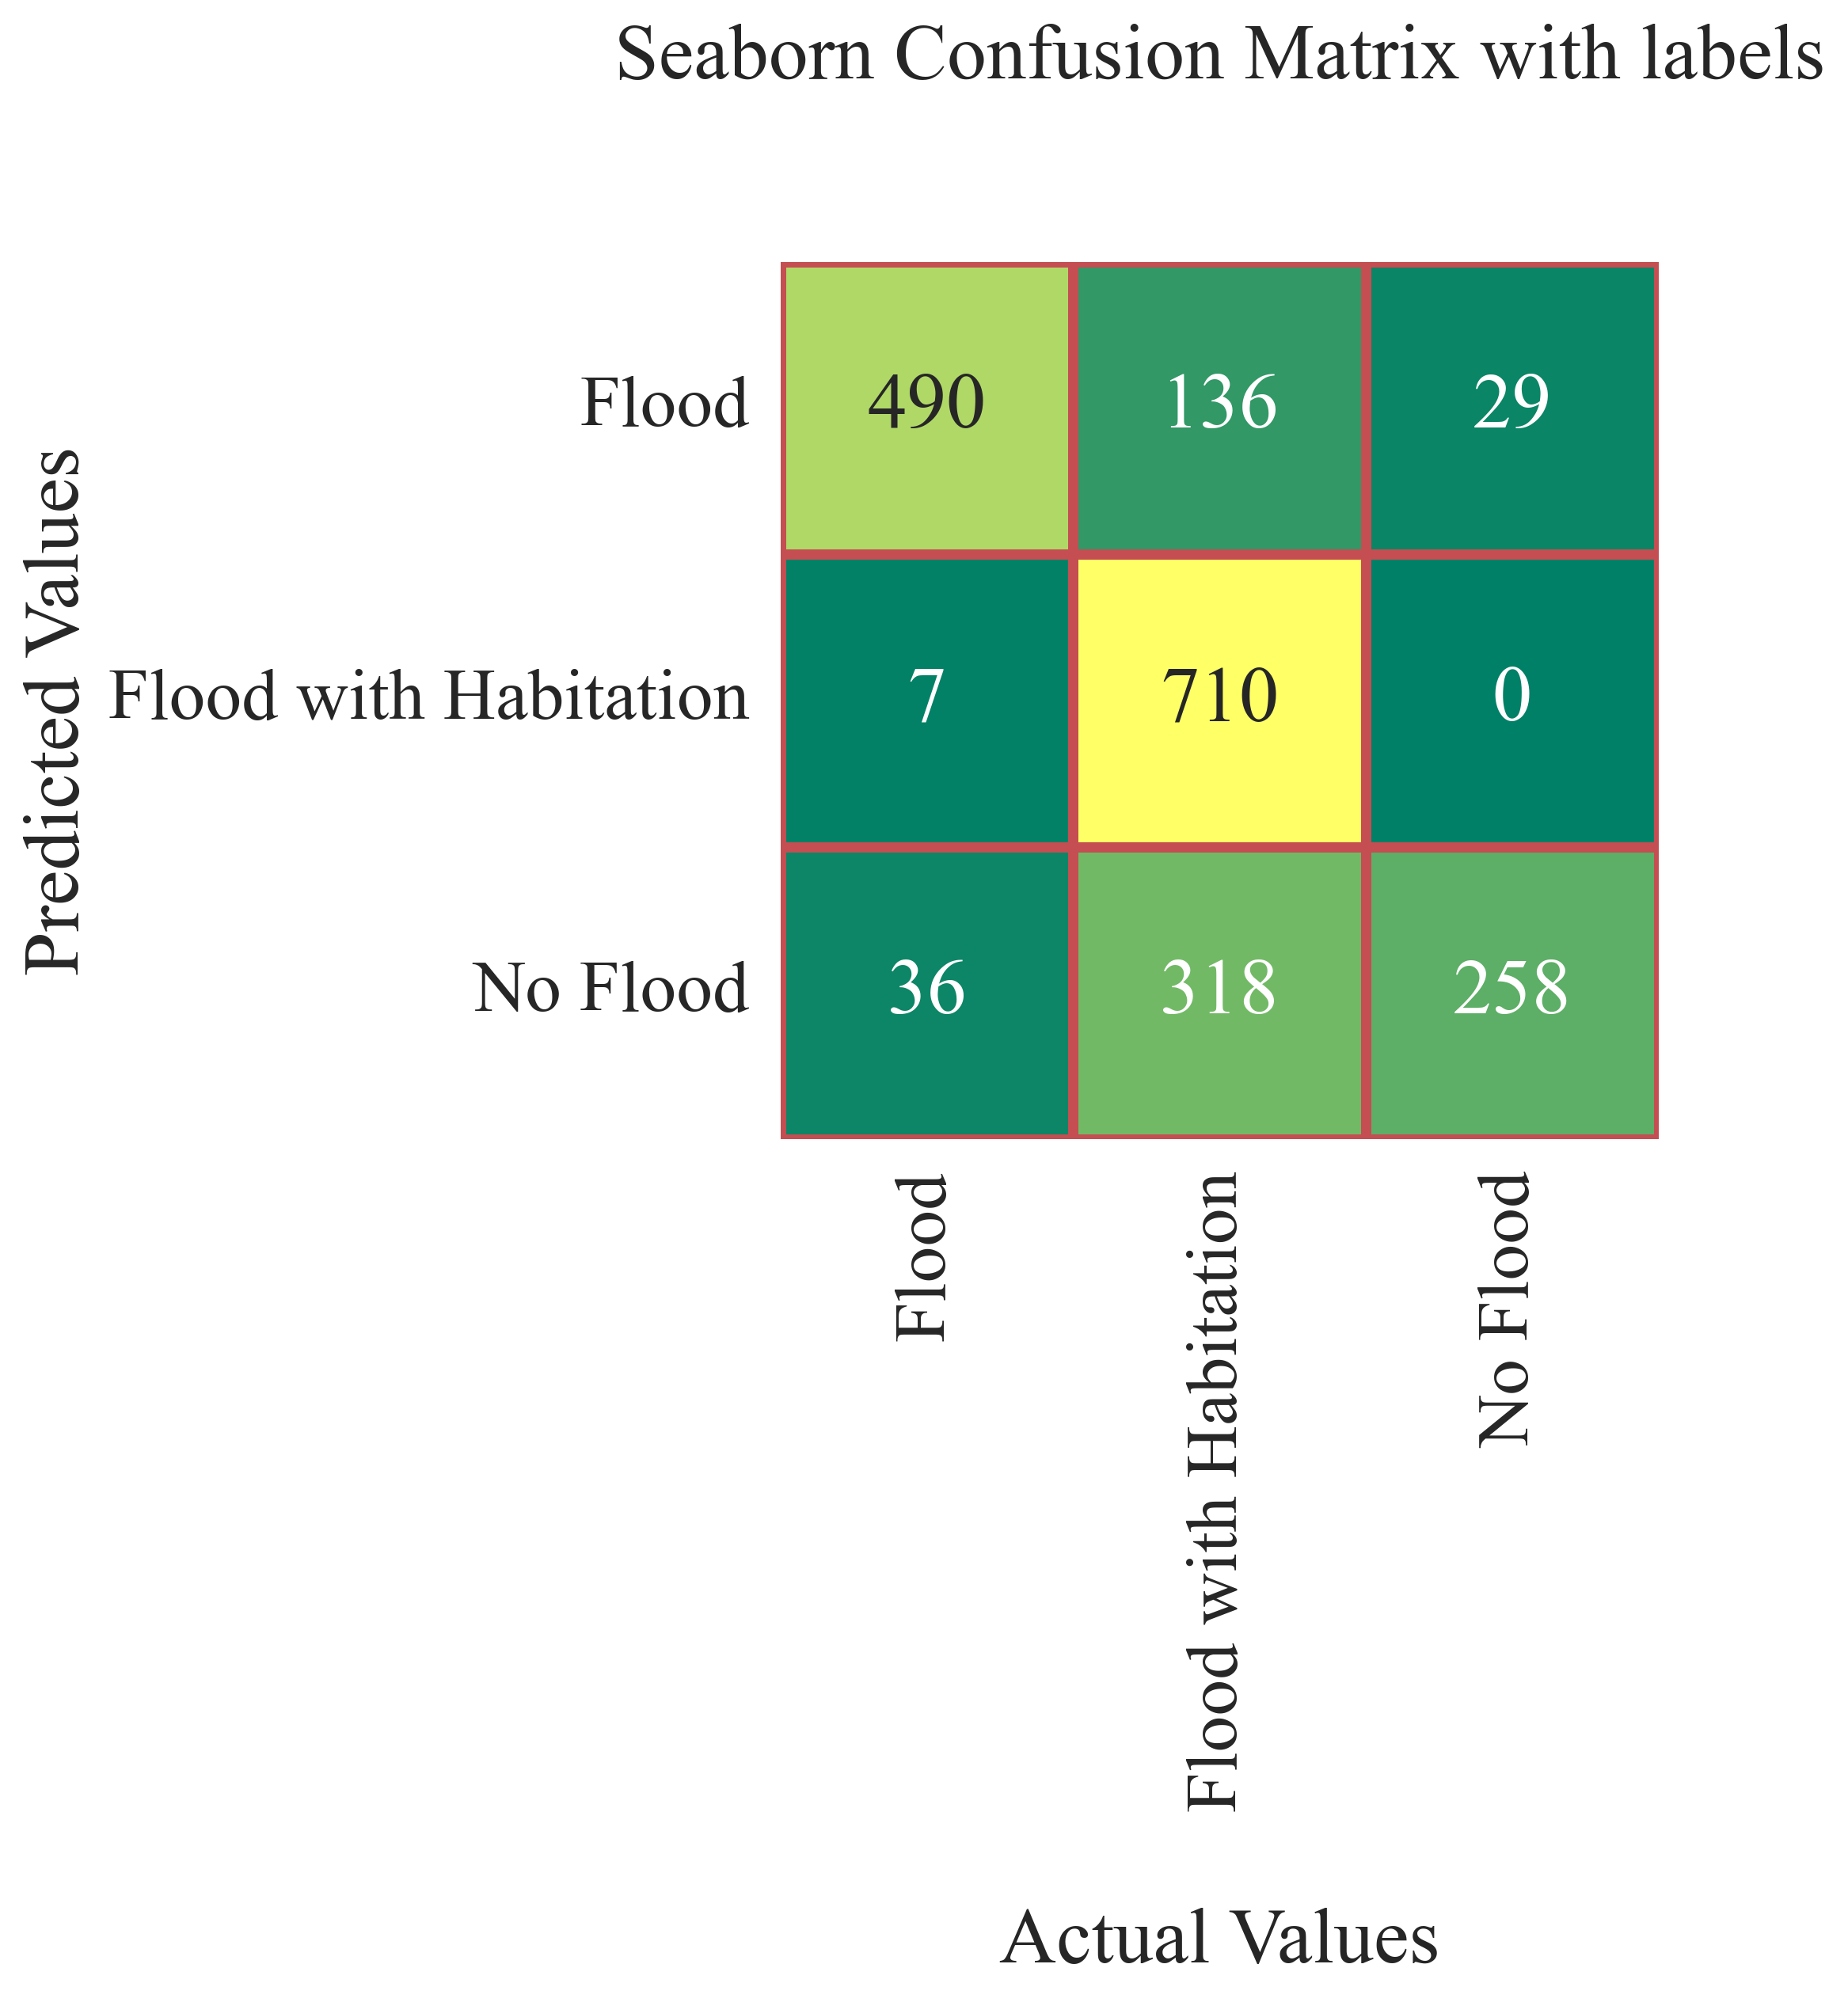

In [94]:
!pip install seaborn
import seaborn as sns

ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams['font.family'] = "Times New Roman"
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

In [95]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_7[0][0]                    
__________________________________________________________________________________________________
patch_extract_6 (PatchExtract)  (None, 1296, 12)     0           data_augmentation[1][0]          
__________________________________________________________________________________________________
patch_embedding_6 (PatchEmbeddi (None, 1296, 64)     83776       patch_extract_6[0][0]            
____________________________________________________________________________________________